In [381]:
import pandas as pd
import matplotlib.pyplot as plt
import pymupdf as fitz
import seaborn as sns
import os

os.chdir(r'C:\Users\baoxi\Documents\TAMU\Fall_2024\RESEARCH_ML\Working')

In [382]:
df = pd.read_csv('combined_data.csv', index_col=0) #header=None
# print(df.to_string())

In [383]:
# sns.heatmap(df.isnull(),
#             cbar = False,
#             cmap = 'viridis',
#             # yticklabels = False
# )

# plt.title('Heatmap for missing data')
# plt.show()

~~**TODO: Fill missing data with imputation**~~
* To resolve this, I opted to replace the missing data points with 0 values.
* This maintains the original ratios without having to manipulate the profit and total variable costs, potentially skewing the data.
* Also, this is accurate because the missing data is not necessarily due to error, but rather simply because the missing value wasn't a relevant cost.

In [384]:
df = df.fillna(0)

In [385]:
transposed_data = df.T
# transposed_data.head()

print(transposed_data.to_string())

Category    Year  Number of Head  Buy Weight  Buy Price  Sell Weight  Sell Price  Total Revenue  Total Variable Costs  Total Fixed Costs  Profit  Stocker  Stocker Purchase  Stocker Delivery  Grazing  Health    Feed  Miscellaneous   Fuel  Lube (As a % of fuel)  Utilities  Repairs  Marketing   Labor  Interest on Credit Line  Depreciation  Equipment Investment  Management Fee, Owner/Operator Labor
0         2019.0           100.0        5.00     176.79         6.50      156.87         968.67               1052.68             136.83 -220.84   968.67            883.95               0.0    50.63    3.13   17.27           9.44  23.88                   2.39       0.00    13.69      19.16    5.00                    24.15         58.34                 78.49                                  0.00
1         2019.0           100.0        4.50     176.79         6.00      157.53         897.92               1044.42             136.83 -283.33   897.92            795.56               0.0    95.63    3.

In [386]:
optimization_data = transposed_data[['Year', 'Stocker Purchase', 'Stocker Delivery', 'Grazing', 'Health', 'Feed', 'Miscellaneous', 'Lube (As a % of fuel)', 'Utilities', 'Repairs', 'Marketing', 'Labor', 'Interest on Credit Line', 'Depreciation', 'Equipment Investment', 'Management Fee, Owner/Operator Labor', 'Profit']].copy()
# weight_data = transposed_data[['Number of Head','Buy Weight','Sell Weight']].copy()
optimization_data['Year'] = optimization_data['Year'].astype(int)
# optimization_data.head()
print(optimization_data.to_string())

Category  Year  Stocker Purchase  Stocker Delivery  Grazing  Health    Feed  Miscellaneous  Lube (As a % of fuel)  Utilities  Repairs  Marketing   Labor  Interest on Credit Line  Depreciation  Equipment Investment  Management Fee, Owner/Operator Labor  Profit
0         2019            883.95               0.0    50.63    3.13   17.27           9.44                   2.39       0.00    13.69      19.16    5.00                    24.15         58.34                 78.49                                  0.00 -220.84
1         2019            795.56               0.0    95.63    3.00   32.10           9.44                   2.39       0.00    13.69      19.16    5.00                    44.58         58.34                 78.49                                  0.00 -283.33
2         2019            775.00               7.5   125.00   25.00    6.75          60.00                   0.00       0.00     0.00       0.00   23.67                    24.47          0.00                  0.00       

**I can approach this modeling problem in multiple ways:**

1. cost optimization using critical spending categories such as grazing, health, feed.

2. other possible approaches to ask gpt: Optimizing the desired buy weight/price, sell weight/price, number of head vs feed / grazing, etc.

# CREATING A MODEL FOR COST OPTIMIZATION

~~**TODO: Adjust data for inflation**~~

In [387]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# # isolating the year data
# year = df.loc['Year'].astype(int)
# df = df.drop('Year')

# reading cpi data from file
cpi_data = pd.read_csv('Key_Economic_Indicators_20241019.csv')

# we only want cpi data.
cpi_data = cpi_data[['Month','Year','Consumer Price Index TX','Consumer Price Index U.S.']]
cpi_data = cpi_data.dropna()

# obtain cpi data from only 2019-2023
cpi_data = cpi_data.loc[cpi_data['Year'].between(2019, 2023)]
cpi_data = cpi_data.groupby('Year').mean().reset_index()

# get the cpi per year
cpi_data = cpi_data[['Year', 'Consumer Price Index TX']].copy()
base_cpi = cpi_data.iloc[4,1]

# combine the cpi data with the optimization data
optimization_data = pd.merge(optimization_data, cpi_data, on='Year', how='left')

for column in optimization_data.columns:
    optimization_data[column] = optimization_data[column] / optimization_data['Consumer Price Index TX'] * base_cpi
    optimization_data[column] = optimization_data[column].round(2)

optimization_data = optimization_data.drop(['Year', 'Consumer Price Index TX'], axis=1)

# optimization_data['Number of Head'] = weight_data['Number of Head']

print(optimization_data.to_string())

    Stocker Purchase  Stocker Delivery  Grazing  Health    Feed  Miscellaneous  Lube (As a % of fuel)  Utilities  Repairs  Marketing   Labor  Interest on Credit Line  Depreciation  Equipment Investment  Management Fee, Owner/Operator Labor  Profit
0            1052.66              0.00    60.29    3.73   20.57          11.24                   2.85       0.00    16.30      22.82    5.95                    28.76         69.47                 93.47                                  0.00 -262.99
1             947.40              0.00   113.88    3.57   38.23          11.24                   2.85       0.00    16.30      22.82    5.95                    53.09         69.47                 93.47                                  0.00 -337.41
2             922.91              8.93   148.86   29.77    8.04          71.45                   0.00       0.00     0.00       0.00   28.19                    29.14          0.00                  0.00                                  0.00  -46.91
3       

**TODO: Model data using ML model**

In [388]:
# obtaining features (X) and target (Y)
X = optimization_data.drop(['Profit'], axis = 1)
y = optimization_data['Profit']

# split data into training / testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create and train the random forest model
rf_regressor = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_regressor.fit(X_train, y_train)


RandomForestRegressor(n_estimators=1000, random_state=42)

**TODO: Test model using other points**

In [389]:
# making predictions on the test set
predictions = rf_regressor.predict(X_test)

# evaluating model performance
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f'R² Score: {r2}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

R² Score: 0.47872919357743793
Mean Absolute Error (MAE): 52.77090933333329
Root Mean Squared Error (RMSE): 62.58967448532206


**TODO: Perform feature importance**

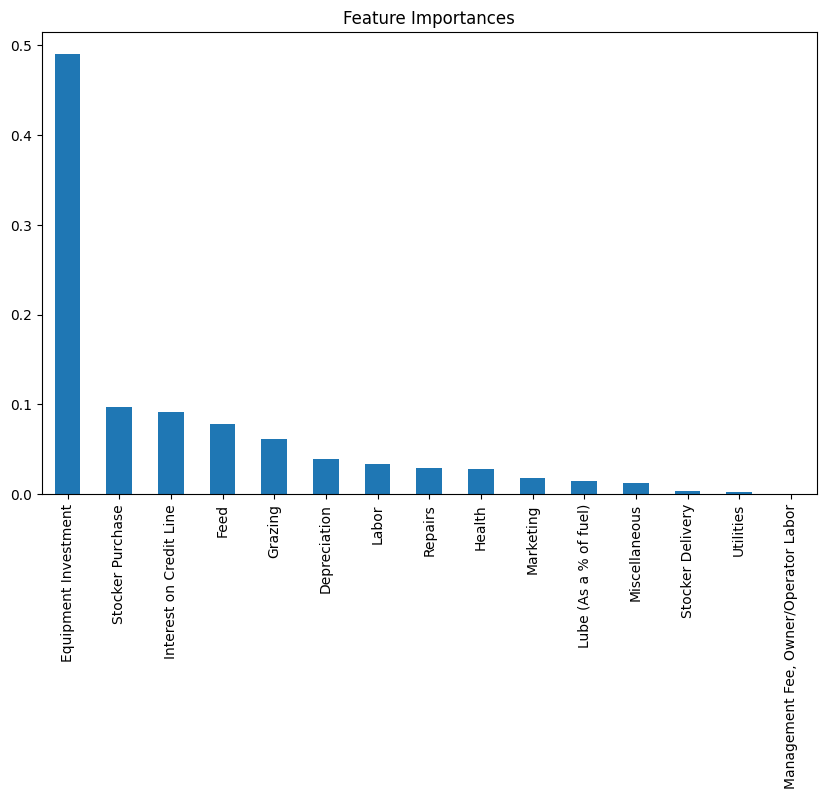

In [390]:
# getting feature importances
feature_importances = pd.Series(rf_regressor.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

# plotting feature importances
plt.figure(figsize=(10,6))
feature_importances.plot(kind='bar')
plt.title('Feature Importances')
plt.show()

**TODO: Check for 'Equipment Investment' correlation with other features**

In [391]:
# creatign a correlation matrix
correlation_matrix = optimization_data.corr()
print(correlation_matrix['Profit'].sort_values(ascending=False))

Profit                                  1.000000
Health                                  0.447930
Feed                                    0.310479
Labor                                   0.212366
Management Fee, Owner/Operator Labor    0.136663
Stocker Delivery                        0.116932
Stocker Purchase                       -0.012834
Grazing                                -0.021445
Utilities                              -0.025218
Miscellaneous                          -0.064107
Marketing                              -0.305618
Interest on Credit Line                -0.375688
Lube (As a % of fuel)                  -0.577952
Depreciation                           -0.642972
Equipment Investment                   -0.696254
Repairs                                -0.712734
Name: Profit, dtype: float64


**TODO: Try to create a new model using the features with greatest significance**

In [392]:
# obtaining new features (X2) and target (y2)
X2 = optimization_data.drop(['Profit', 'Stocker Purchase', 'Grazing', 'Utilities', 'Miscellaneous'], axis = 1)
y2 = optimization_data['Profit']

# split data into training / testing sets
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

# create and train the random forest model
rf_regressor2 = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_regressor2.fit(X2_train, y_train)


RandomForestRegressor(n_estimators=1000, random_state=42)

In [393]:
# making predictions on the test set
predictions2 = rf_regressor2.predict(X2_test)

# evaluating model performance
mae2 = mean_absolute_error(y2_test, predictions2)
r2_2 = r2_score(y2_test, predictions2)

print(mae2, r2_2)

53.43972399999995 0.401600372822555


**TODO: Perform hyperparameter tuning on Random Forest Model**

In [394]:
from sklearn.model_selection import RandomizedSearchCV

# defining parameter gridd
param_grid = {
    'n_estimators': [100,500,1000],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4],
    'max_features': ['log2','sqrt', None]
}

# initialize RandomizedSearchCV
rf_random_search = RandomizedSearchCV(estimator=rf_regressor, param_distributions=param_grid, n_iter=50, cv=3, random_state=42, n_jobs=-1, scoring='r2')

# fit to find the best parameters
rf_random_search.fit(X_train, y_train)

# output the best parameters
print('Best Parameters:', rf_random_search.best_params_)

# use the best estimator
rf_best = rf_random_search.best_estimator_


Best Parameters: {'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20}


In [395]:
predictions = rf_best.predict(X_test)

# evaluating tuned model performance
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f'R² Score: {r2}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

R² Score: 0.507056187701086
Mean Absolute Error (MAE): 49.49862799999985
Root Mean Squared Error (RMSE): 60.865290767051626


# TRYING OUT SOME OTHER MODELS:

**TODO: Creating a Linear Regression Model**

In [396]:
from sklearn.linear_model import LinearRegression

# initialize the linear regression model
lin_reg = LinearRegression()

# train the model on the training set
lin_reg.fit(X_train, y_train)

# making predictions on test set
predictions = lin_reg.predict(X_test)

# evaluating model performance
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f'R² Score: {r2}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

R² Score: -0.05709606055859706
Mean Absolute Error (MAE): 72.66546019009893
Root Mean Squared Error (RMSE): 89.13088495266717


**TODO: Creating an XGBoost Model**

In [397]:
from xgboost import XGBRegressor

# creating an XGBoost regressor
xgb_reg = XGBRegressor(n_estimators=1000)

# training the model
xgb_reg.fit(X_train, y_train)

# making predictions based on model
y_pred = xgb_reg.predict(X_test)

# evaluating model performance
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'R² Score: {r2}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

R² Score: 0.46619455202160287
Mean Absolute Error (MAE): 46.05704835128783
Root Mean Squared Error (RMSE): 63.33772969333953


**TODO: Perform hyperparameter tuning on XGBoost Regressor Model**

In [398]:
from sklearn.model_selection import GridSearchCV

# defining parameters to tune
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# tuning the model parameters
grid_search = GridSearchCV(XGBRegressor(random_state=42), param_grid, cv=3, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

# evaluating and choosing best parameters
print('Best Parameters:', grid_search.best_params_)
best_model = grid_search.best_estimator_

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}


In [399]:
y_pred_tuned = best_model.predict(X_test)

# evaluating tuned model performance
mae = mean_absolute_error(y_test, y_pred_tuned)
r2 = r2_score(y_test, y_pred_tuned)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_tuned))

print(f'R² Score: {r2}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

R² Score: 0.4803802985101695
Mean Absolute Error (MAE): 49.328451596419015
Root Mean Squared Error (RMSE): 62.49047069153755


**TODO: Create an ARIMA Model.**